### Parameters

**wetb**: Wet bulb Air Temperature(°C) is used to measure the extent of cooling as moisture dries on a surface.

**dewpt**: Dew point Air Temperature(°C) is used to determine the temperature at which the air can no longer retain moisture. This figure should always be less than or equal to the value of the actual temperature. If air temperature cools to dew point, or the dew point rises to the current temperature then fog or clouds appear. Sourced: http://www.weatherquestions.com/What_is_dewpoint_temperature.htm

**vappr**: Vapour Pressure(hpa) 

**rhum**: Relative Humidity	describes how close the air is to saturation with moisture. Therefore a high relative humidity (100%) indicates theres more moisture in the air.


**msl**: Mean Sea Level Pressure is the atmospheric pressure recorded at sea.

#### Recurrent Neural Networks.
One of the best neural network architectures for predicting "the future", in this case future weather forecasts. Work quite well with time series data which is what I have here.

Suffer from vanishing/exploding gradients. LSTM and GRU cells used to combat this.

In [76]:
import pandas as pd
import numpy as np
import datetime as dt
import mysql.connector
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
from pandas.core import datetools
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler

sns.set_style('darkgrid')
pd.options.display.float_format = '{:,.2f}'.format

In [2]:
def create_connection():
    cnx2 = mysql.connector.connect(host='localhost',
                                   user='root', password='MyNewPass',
                                   database='Weather_Data')
    return cnx2

In [3]:
def select_data():
    conn = create_connection()
    cursor = conn.cursor()
    print('Extracting Data')
    query = "Select * from weather;"
    cursor.execute(query, )
    result = cursor.fetchall()
    print('Extracted Data')
        
    cursor.close()
    conn.close()
    
    return result
    

In [4]:
def change_structure(data):
    cols = ['date', 'rain', 'temp', 'wetb', 'dewpt','vappr', 'rhum', 'msl', 'wdsp', 'wddir','height','latitude', 'longitude', 'station','county']
    data = pd.DataFrame(data, columns=cols)
    
    data.fillna(0, inplace=True)
    return data

In [5]:
def split_time(data):
    data['date'] = pd.to_datetime(data['date'])
    data['year'] = data['date'].dt.year
    data['month'] = data['date'].dt.month.astype(np.uint8)
    data['day'] = data['date'].dt.day.astype(np.uint8)
    data['hour'] = data['date'].dt.hour.astype(np.uint8)
    
    return data

In [6]:
def generate_season(data):
    data['season'] = pd.cut(data['month'], bins=[0, 3, 6,9,12], labels=[1,2,3,4])
    return data

In [7]:
def mean_features(data):
    # mean rain, temp, windsp, windirection by year, by season
    group = ['year', 'season','month','station']
    features = ['rain', 'temp', 'wdsp', 'wddir']
    
    for grouping in group:
        for predictor in features:
            print('Grouping by ',grouping, ' getting average ', predictor )
            
            new_var = predictor + '_by_' + grouping
            temp = data.groupby(grouping)[predictor].mean().reset_index() 
            temp.columns = [grouping, new_var]
            data = data.merge(temp, how='left', on=grouping)
    
    return data

In [8]:
def plot_hour_vs_rain(data):    
    sns.lmplot(x='hour', y='rain', data = data, fit_reg=True, scatter_kws={"alpha":0.25, 's':.2}, line_kws={"color":"r"})
    plt.title('Hour vs. Mean Rainfall(mm) Including Regression Line')

In [9]:
def plot_hour_vs_temp(data):    
    sns.lmplot(x='hour', y='temp', data = data, fit_reg=True,scatter_kws={"alpha":0.25, 's':.2}, line_kws={"color":"r"})
    plt.title('Hour vs. Mean Temperature(°C) Including Regression Line')

In [10]:
def plot_hour_vs_wdsp(data):    
    sns.lmplot(x='hour', y='wdsp', data = data, fit_reg=True,scatter_kws={"alpha":0.25, 's':.2}, line_kws={"color":"r"})
    plt.title('Hour vs. Mean Wind Speed(KT) Including Regression Line')

In [11]:
def plot_by_year(data):
    data = data.sort_values('year')
    
    plt.figure(figsize=(15,15))
    plt.suptitle('Yearly Averages')
    
    plt.subplot(221)
    plt.plot('year', 'rain_by_year', data=data, color="orange")
    plt.xticks(np.arange(data['year'].min(), data['year'].max()) )
    plt.xlabel('Year', fontweight='bold', color = 'orange', fontsize='14')
    plt.ylabel('Average Rainfall by Year', fontweight='bold', color = 'orange', fontsize='14')
    plt.xticks(rotation=75)
    
    plt.subplot(222)
    plt.plot('year', 'temp_by_year', data=data, color="green")
    plt.xticks(np.arange(data['year'].min(), data['year'].max()) )
    plt.xlabel('Year', fontweight='bold', color = 'orange', fontsize='14')
    plt.ylabel('Average Temperature by Year', fontweight='bold', color = 'orange', fontsize='14')
    plt.xticks(rotation=75)
    
    plt.subplot(223)
    plt.plot('year', 'wdsp_by_year', data=data, color="blue")
    plt.xticks(np.arange(data['year'].min(), data['year'].max()) )
    plt.xlabel('Year', fontweight='bold', color = 'orange', fontsize='14')
    plt.ylabel('Average Windspeed by Year', fontweight='bold', color = 'orange', fontsize='14')
    plt.xticks(rotation=75)
    
    plt.subplot(224)
    plt.plot('year', 'wddir_by_year', data=data, color="red")
    plt.xticks(np.arange(data['year'].min(), data['year'].max()) )
    plt.xlabel('Year', fontweight='bold', color = 'orange', fontsize='14')
    plt.ylabel('Average Wind Direction by Year', fontweight='bold', color = 'orange', fontsize='14')
    plt.xticks(rotation=75)
    
    plt.savefig('Yearly Averages.png')

    
    plt.show()

In [12]:
def plot_by_season(data):
    data['season'].astype('category')
    data = data.sort_values('season')
    
    plt.figure(figsize=(15,15))
    plt.suptitle('Season Averages')
    
    plt.subplot(221)
    plt.bar('season','rain_by_season', data=data ,color="orange")
    plt.xlabel('Season', fontweight='bold', color = 'orange', fontsize='14')
    plt.ylabel('Average Rainfall by Season', fontweight='bold', color = 'orange', fontsize='14')
    
    plt.subplot(222)
    plt.bar('season', 'temp_by_season', data=data, color="green")
    plt.xlabel('Season', fontweight='bold', color = 'orange', fontsize='14')
    plt.ylabel('Average Temperature by Season', fontweight='bold', color = 'orange', fontsize='14')
    
    plt.subplot(223)
    plt.bar('season', 'wdsp_by_season', data=data, color="blue")
    plt.xlabel('Season', fontweight='bold', color = 'orange', fontsize='14')
    plt.ylabel('Average Windspeed by Season', fontweight='bold', color = 'orange', fontsize='14')
    
    plt.subplot(224)
    plt.bar('season', 'wddir_by_season', data=data, color="red")
    plt.xlabel('Season', fontweight='bold', color = 'orange', fontsize='14')
    plt.ylabel('Average Wind Direction by Season', fontweight='bold', color = 'orange', fontsize='14')
    
    plt.savefig('Seasonal Averages.png')
    
    plt.show()

In [13]:
def plot_by_station(data):
    data['station'].astype('category')
    data = data.sort_values('station')
    
    plt.figure(figsize=(18,18))
    plt.suptitle('Station Averages')
    
    plt.subplot(221)
    plt.plot('station', 'rain_by_station', data=data, color="orange")
    plt.xlabel('Station', fontweight='bold', color = 'orange', fontsize='14')
    plt.ylabel('Average Rainfall by Station', fontweight='bold', color = 'orange', fontsize='14')
    plt.xticks(rotation=75)
    
    plt.subplot(222)
    plt.plot('station', 'temp_by_station', data=data, color="green")
    plt.xlabel('Station', fontweight='bold', color = 'orange', fontsize='14')
    plt.ylabel('Average Temperature by Station', fontweight='bold', color = 'orange', fontsize='14')
    plt.xticks(rotation=75)
    
    plt.subplot(223)
    plt.plot('station', 'wdsp_by_station', data=data, color="blue")
    plt.xlabel('Station', fontweight='bold', color = 'orange', fontsize='14')
    plt.ylabel('Average Windspeed by Station', fontweight='bold', color = 'orange', fontsize='14')
    plt.xticks(rotation=75)
    
    plt.subplot(224)
    plt.plot('station', 'wddir_by_station', data=data, color="red")
    plt.xlabel('Station', fontweight='bold', color = 'orange', fontsize='14')
    plt.ylabel('Average Wind Direction by Station', fontweight='bold', color = 'orange', fontsize='14')
    plt.xticks(rotation=75)
    
    plt.savefig('Station Averages.png')
    
    plt.show()

In [14]:
def plot_by_month(data):
    data['month'].astype('category')
    data = data.sort_values('month')
    
    plt.figure(figsize=(15,15))
    plt.suptitle('Station Averages')
    
    plt.subplot(221)
    plt.plot('month', 'rain_by_month', data=data, color="orange")
    plt.xlabel('Month', fontweight='bold', color = 'orange', fontsize='14')
    plt.ylabel('Average Rainfall by Month', fontweight='bold', color = 'orange', fontsize='14')
    
    plt.subplot(222)
    plt.plot('month', 'temp_by_month', data=data, color="green")
    plt.xlabel('Month', fontweight='bold', color = 'orange', fontsize='14')
    plt.ylabel('Average Temperature by Month', fontweight='bold', color = 'orange', fontsize='14')
    
    plt.subplot(223)
    plt.plot('month', 'wdsp_by_month', data=data, color="blue")
    plt.xlabel('Month', fontweight='bold', color = 'orange', fontsize='14')
    plt.ylabel('Average Windspeed by Month', fontweight='bold', color = 'orange', fontsize='14')
    
    plt.subplot(224)
    plt.plot('month', 'wddir_by_month', data=data, color="red")
    plt.xlabel('Month',fontweight='bold', color = 'orange', fontsize='14')
    plt.ylabel('Average Wind Direction by Month', fontweight='bold', color = 'orange', fontsize='14')
    
    plt.savefig('Monthly Averages.png')
    
    plt.show()

In [45]:
def create_sets(data):
    max_index = len(data)
    
    start_train = 0
    end_train = round(max_index//2)

    start_validation = end_train + 1
    end_validation = round(start_validation + (max_index - end_train) // 2)

    start_test = end_validation + 1
    end_test = max_index

    train = data[start_train:end_train]
    validation = data[start_validation:end_validation]
    test = data[start_test:end_test]
    
    return train, validation, test

In [97]:
def create_linear_models(data):
    data = data.sort_values('date')
    targets = ['wdsp','wddir','rain','temp']
    
    del(data['station'])
    del(data['county'])
    del(data['date'])
    
    for target in targets:
        temp = data
        
        #Scale data - MinMax scaler scales between 0 and 1. Means now have lowers standard deviations so effects of outliers are minimised
        #StandardScalers scales data so it has mean 0 and standard deviation of 1
        
        scaler = StandardScaler()
        temp = scaler.fit_transform(temp)

        # Split into train ,validation and test sets
        train, validation, test = create_sets(temp)
        temp = pd.DataFrame(temp)
       
        train_target, validation_target, test_target = create_sets(temp[32])

        del(temp[32])
        
        print('Performing linear regression on ',target)

        reg = LinearRegression().fit(train,train_target)
        target_predictions = reg.predict(validation)
        
        
        
        #print("Mean squared error: ", mean_squared_error(validation_target, target_predictions))
        print('Variance score: ', r2_score(validation_target, target_predictions))
        
        print('Performing Random forest regression on ',target)

        reg = RandomForestRegressor().fit(train,train_target)
        target_predictions = reg.predict(validation)
        
        
        
        print('Variance score: ', r2_score(validation_target, target_predictions))
        
        #print('Performing MLP regression on ',target)

        #reg = MLPRegressor().fit(train,train_target)
        #target_predictions = reg.predict(validation)
        
        
        
        #print('Variance score: ', r2_score(validation_target, target_predictions))
    
    

In [105]:
def get_vif(data):
    #https://etav.github.io/python/vif_factor_python.html
    
    data = data._get_numeric_data() 
    print(data.columns)
    targets = ['wdsp','temp','wddir','rain']
    for target in targets:
        features = '+'.join(data.loc[:, data.columns != target].columns)
        print('Performing Regression on: ', target)
        y, X = dmatrices(target + ' ~ ' + features, data, return_type='dataframe')
        print('Finished Regression on: ', target)
        
        #X represents the coefficients, y represents the output 
        
        
        #Cant calculate variance inflation factor as R2 is 1. Vif formula is 1/1-R2 which means its trying to divide by 0
        vif = pd.DataFrame()
        vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
        vif["features"] = X.columns
        print(vif)
    

In [17]:
data = select_data()
data = change_structure(data)

Extracting Data
Extracted Data


In [18]:
data = split_time(data)

In [19]:
data = generate_season(data)

In [20]:
data = mean_features(data)

Grouping by  year  getting average  rain


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


Grouping by  year  getting average  temp


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


Grouping by  year  getting average  wdsp


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


Grouping by  year  getting average  wddir


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


Grouping by  season  getting average  rain


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


Grouping by  season  getting average  temp


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


Grouping by  season  getting average  wdsp


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


Grouping by  season  getting average  wddir


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


Grouping by  month  getting average  rain


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


Grouping by  month  getting average  temp


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


Grouping by  month  getting average  wdsp


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


Grouping by  month  getting average  wddir


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


Grouping by  station  getting average  rain


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


Grouping by  station  getting average  temp


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


Grouping by  station  getting average  wdsp


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


Grouping by  station  getting average  wddir


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


CPU times: user 15min 58s, sys: 1min 53s, total: 17min 51s
Wall time: 7min 13s


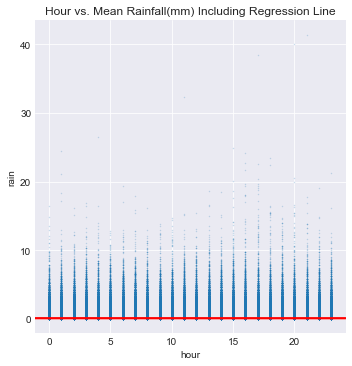

In [21]:
%time plot_hour_vs_rain(data)

CPU times: user 15min 48s, sys: 1min 53s, total: 17min 41s
Wall time: 7min 4s


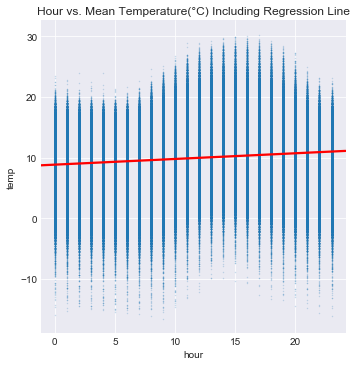

In [22]:
%time plot_hour_vs_temp(data)

CPU times: user 15min 56s, sys: 1min 44s, total: 17min 41s
Wall time: 6min 52s


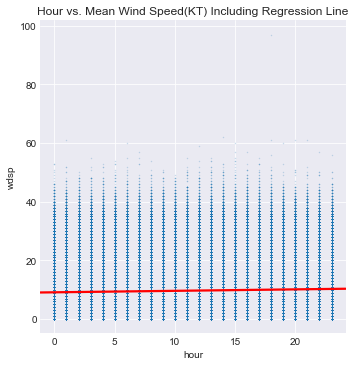

In [23]:
%time plot_hour_vs_wdsp(data)

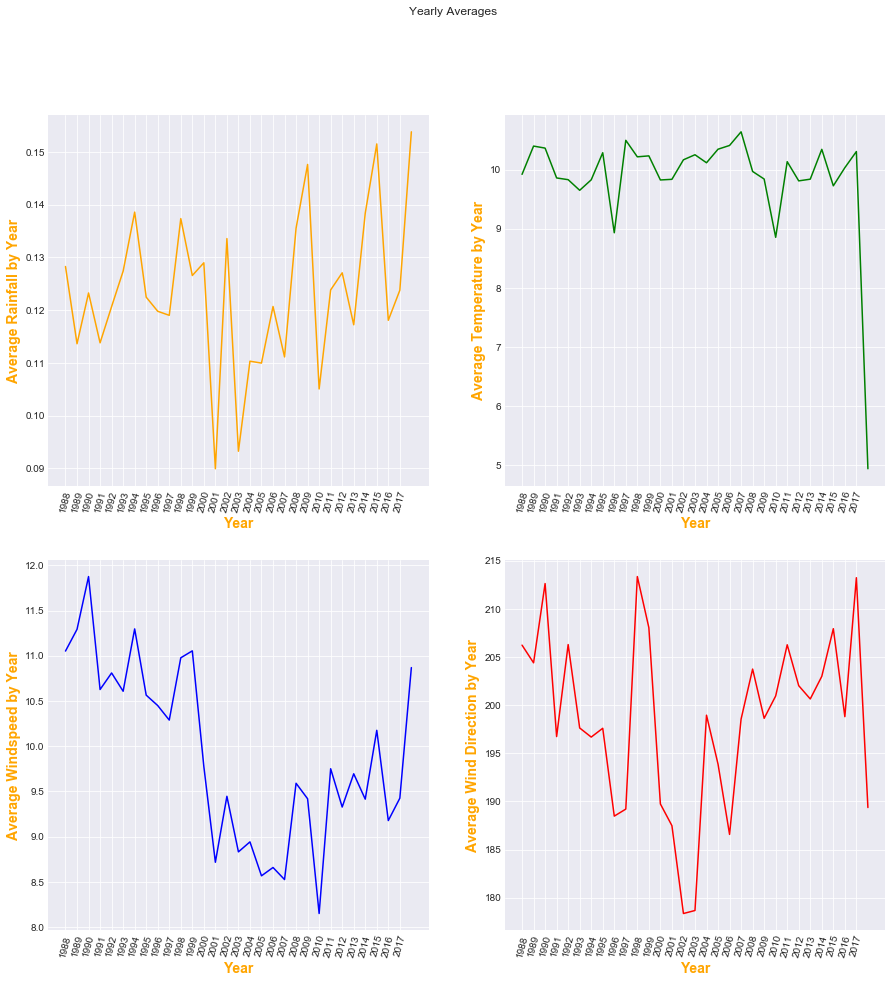

CPU times: user 8.46 s, sys: 3.83 s, total: 12.3 s
Wall time: 12.9 s


In [24]:
%time plot_by_year(data)

In [25]:
#%time plot_by_season(data)

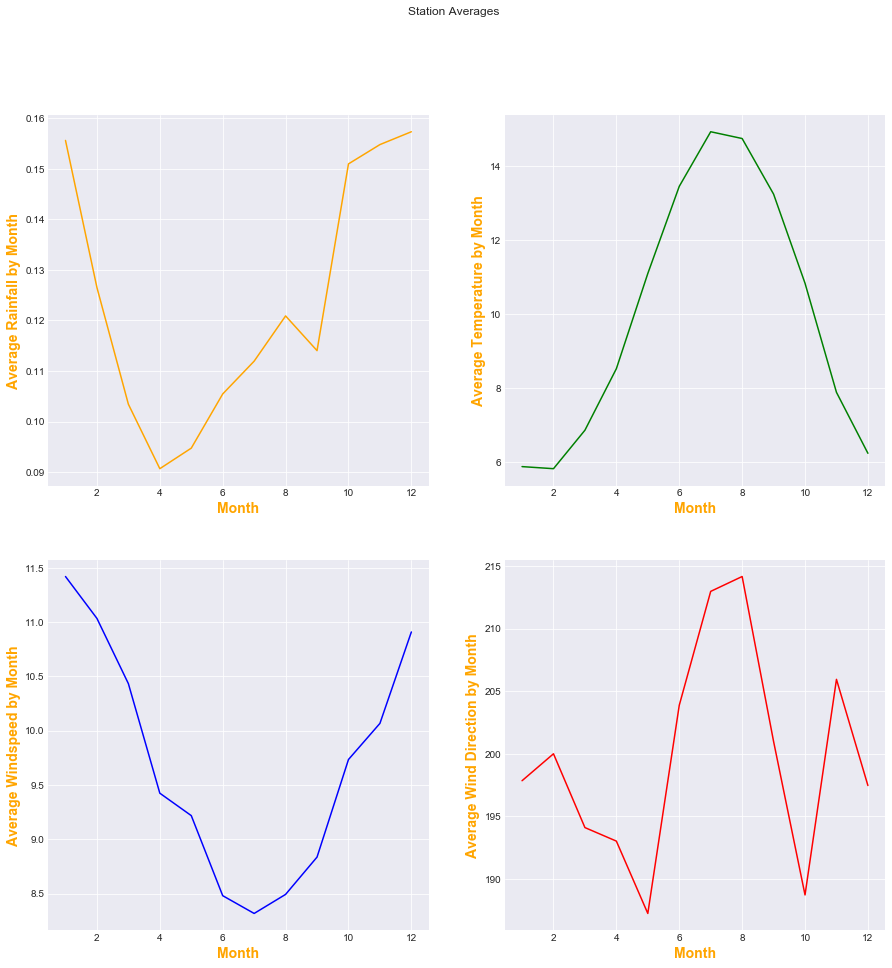

CPU times: user 7.33 s, sys: 3.41 s, total: 10.7 s
Wall time: 11.4 s


In [26]:
%time plot_by_month(data)

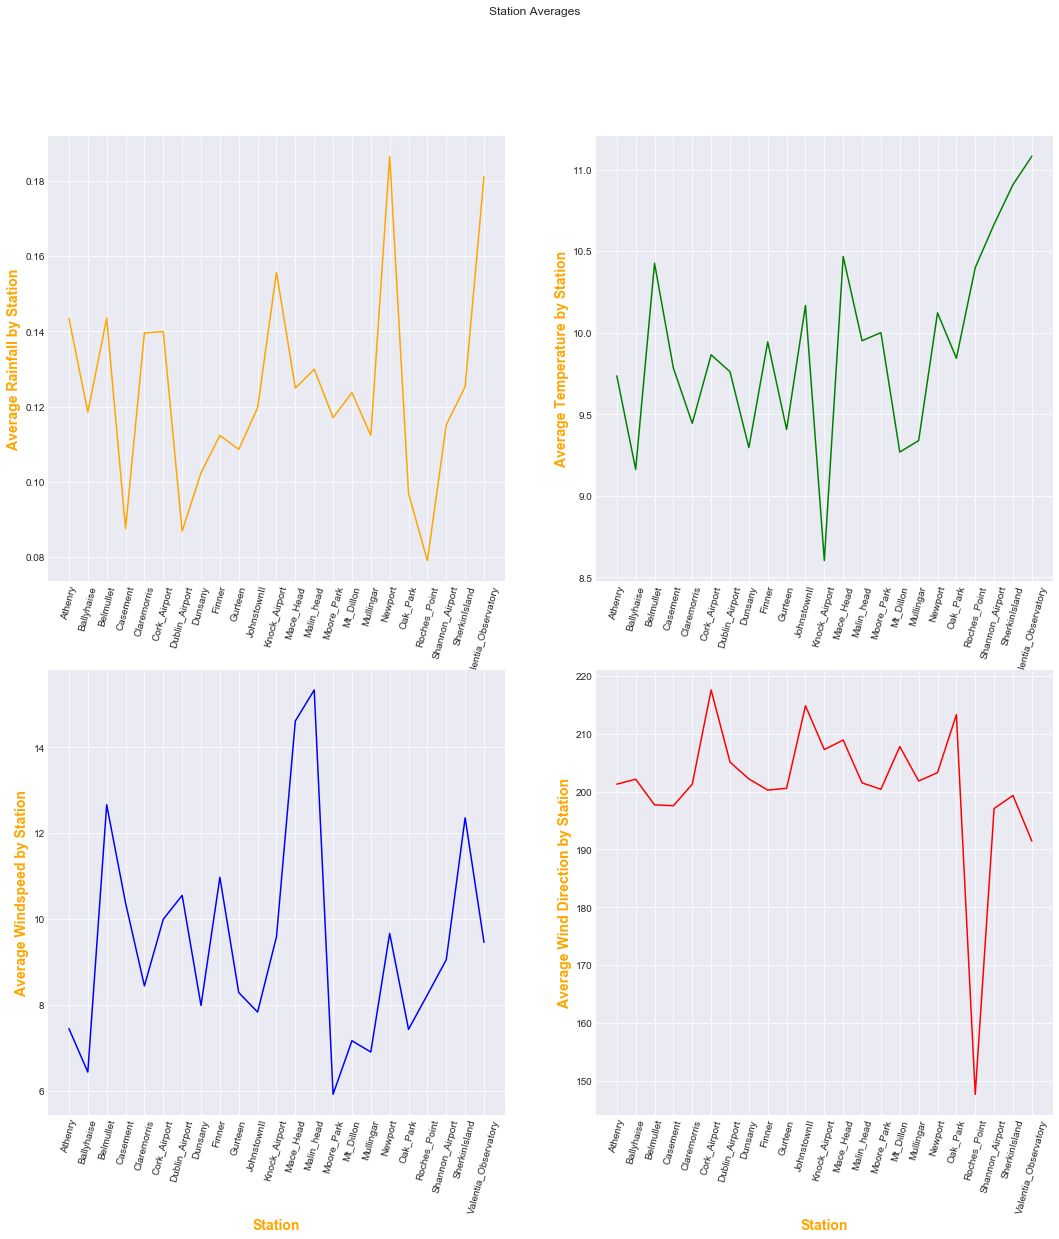

CPU times: user 4min 21s, sys: 14 s, total: 4min 35s
Wall time: 4min 39s


In [27]:
%time plot_by_station(data)

In [74]:
create_linear_models(data)

start
a
b
c
d
0
1
2
3
1986448
993224
993223
Basic split complete
rain
<class 'pandas.core.frame.DataFrame'>
           0     1     2     3     4     5     6     7     8     9   ...   \
0        0.36 -0.35 -0.36 -0.36 -0.39  0.01 -0.20  3.08  0.55 -0.88  ...    
1        1.59 -0.18  0.03  0.28  0.20  0.87 -0.07  0.85  0.11 -0.80  ...    
2       -0.25 -0.63 -0.62 -0.56 -0.57  0.15 -0.11  1.01  0.33  0.16  ...    
3       -0.05 -0.71 -0.71 -0.65 -0.63  0.15 -0.10  1.96  0.33  0.56  ...    
4       -0.25 -0.16 -0.39 -0.67 -0.63 -0.78 -0.14  1.33  0.55 -1.10  ...    
5       -0.25 -0.41 -0.34 -0.23 -0.27  0.41 -0.06  0.85  0.22  1.86  ...    
6       -0.25 -0.74 -0.69 -0.56 -0.57  0.34 -0.11  0.85  0.33  0.77  ...    
7       -0.05 -0.31 -0.27 -0.18 -0.24  0.21 -0.09  0.21  0.22 -0.98  ...    
8       -0.25 -0.71 -0.62 -0.43 -0.45  0.54 -0.12 -0.59  0.33  0.10  ...    
9       -0.25 -0.16 -0.06  0.06 -0.01  0.41 -0.05  0.69  0.22 -0.47  ...    
10      -0.25 -0.82 -0.73 -0.56 -0.57  0.54 -

Performing linear regression on  rain
Variance score:  1.0
Performing Random forest regression on  rain
Variance score:  0.999951499628
start
a
b
c
d
0
1
2
3
1986448
993224
993223
Basic split complete
temp
<class 'pandas.core.frame.DataFrame'>
           0     1     2     3     4     5     6     7     8     9   ...   \
0        0.36 -0.35 -0.36 -0.36 -0.39  0.01 -0.20  3.08  0.55 -0.88  ...    
1        1.59 -0.18  0.03  0.28  0.20  0.87 -0.07  0.85  0.11 -0.80  ...    
2       -0.25 -0.63 -0.62 -0.56 -0.57  0.15 -0.11  1.01  0.33  0.16  ...    
3       -0.05 -0.71 -0.71 -0.65 -0.63  0.15 -0.10  1.96  0.33  0.56  ...    
4       -0.25 -0.16 -0.39 -0.67 -0.63 -0.78 -0.14  1.33  0.55 -1.10  ...    
5       -0.25 -0.41 -0.34 -0.23 -0.27  0.41 -0.06  0.85  0.22  1.86  ...    
6       -0.25 -0.74 -0.69 -0.56 -0.57  0.34 -0.11  0.85  0.33  0.77  ...    
7       -0.05 -0.31 -0.27 -0.18 -0.24  0.21 -0.09  0.21  0.22 -0.98  ...    
8       -0.25 -0.71 -0.62 -0.43 -0.45  0.54 -0.12 -0.59  0.33  

Performing linear regression on  temp
Variance score:  1.0
Performing Random forest regression on  temp


KeyboardInterrupt: 

In [106]:
get_vif(data)

Index(['rain', 'temp', 'wetb', 'dewpt', 'vappr', 'rhum', 'msl', 'wdsp',
       'wddir', 'height', 'latitude', 'longitude', 'year', 'month', 'day',
       'hour', 'rain_by_year', 'temp_by_year', 'wdsp_by_year', 'wddir_by_year',
       'rain_by_season', 'temp_by_season', 'wdsp_by_season', 'wddir_by_season',
       'rain_by_month', 'temp_by_month', 'wdsp_by_month', 'wddir_by_month',
       'rain_by_station', 'temp_by_station', 'wdsp_by_station',
       'wddir_by_station'],
      dtype='object')
Performing Regression on:  wdsp
Finished Regression on:  wdsp


KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(30,30))
plt.title('Feature Correlation', fontsize=20)
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(data.corr(),square=True, cmap=cmap, linewidths=.5, cbar_kws={"shrink": .5})
plt.savefig('Correlation.png')
plt.show()